In [44]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math

# List of visits to be considered
#visits = [849375, 850587, 907254, 995367, 996234, 850181, 906675, 912206, 995974, 996717]
visits = [849375, 850587]

# Reference visit
ref = 849375

# Tract
tract = 1

# List of CCD to be considered (source calatlogs will be concateneted)
ccd = [12, 13, 14, 21, 22, 23]
# ccd = [21, 22]
#ccd = [14]

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir")

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=int, doc="CCD number")
        
        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
    
    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

mag = []
oldDist = []
newDist = []
for v in visits :
    if v == ref :
        continue
    for indx, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        oldSrc = butler.get('src', dataid, immediate=True)
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
        
            #create the new extented source catalog 
            srcVis = afwTable.SourceCatalog(newSchema)
    
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcVis.extend(tmpCat, deep=False)
        
    print "c", len(srcVis)
    
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in Flags :
            if mRef.get(f) or mVis.get(f) :
                continue
        
        # cleanup the reference sources in order to keep only decent star-like objects
        if mRef.get("base_ClassificationExtendedness_value") >= 1.0 or mVis.get("base_ClassificationExtendedness_value") >= 1.0 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        
        # retrieve the CCD corresponding to the reference source
        ccdRef = mRef.get('ccd')
        ccdVis = mVis.get('ccd')
        
        # retrieve the calibration object associated to the CCDs
        didRef = {'visit':ref, 'filter':filter, 'ccd':ccdRef}
        didRef2 = {'visit':ref, 'filter':filter, 'ccd':ccdRef, 'tract':tract}
        mdRef = butler.get("calexp_md", didRef, immediate=True)
        calib = afwImage.Calib(mdRef)
        # compute magnitude
        flux = mRef.get('base_CircularApertureFlux_5_flux')
        if flux > 0. :
            refMag = calib.getMagnitude(flux)
        else :
            continue
        
        # retrieve the improved wcs and update the coordinate accordingly
        oldWcsRef = afwImage.TanWcs.cast(afwImage.makeWcs(mdRef))
        oldCoordRef = mRef.get("coord")
        pixelsRef = oldWcsRef.skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
        
        newWcsRefCont = butler.get('wcs', didRef2, immediate=True)
        newWcsRef = afwImage.TanWcs.cast(newWcsRefCont.getWcs())
        newCoordRef = newWcsRef.pixelToSky(pixelsRef).toIcrs()
        
        didVis = {'visit':v, 'filter':filter, 'ccd':ccdVis}
        didVis2 = {'visit':v, 'filter':filter, 'ccd':ccdVis, 'tract':tract}
        mdVis = butler.get("calexp_md", didVis, immediate=True)
        oldWcsVis = afwImage.TanWcs.cast(afwImage.makeWcs(mdVis))
        oldCoordVis = mVis.get("coord")
        pixelsVis = oldWcsVis.skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
        newWcsVisCont = butler.get('wcs', didVis2, immediate=True)
        newWcsVis = afwImage.TanWcs.cast(newWcsVisCont.getWcs())
        newCoordVis = newWcsVis.pixelToSky(pixelsVis).toIcrs()
        
        newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       
                                    
        mag.append(refMag)
        oldDist.append(ang)
        newDist.append(newAngle)
        
        if refMag<20 and ang>400 :
            print v, ang, refMag, ccdRef, mRef.get('coord'), mRef.get('base_SdssCentroid_x'), mRef.get('base_SdssCentroid_y'), mVis.get('base_SdssCentroid_x'), mVis.get('base_SdssCentroid_y')
            print mVis.get('base_PixelFlags_flag_edge')

12 1067
13 1082
14 1046
21 1100
22 1106
23 1120
Ref... 6521
c 10343
Visit : 850587 5634 matches found


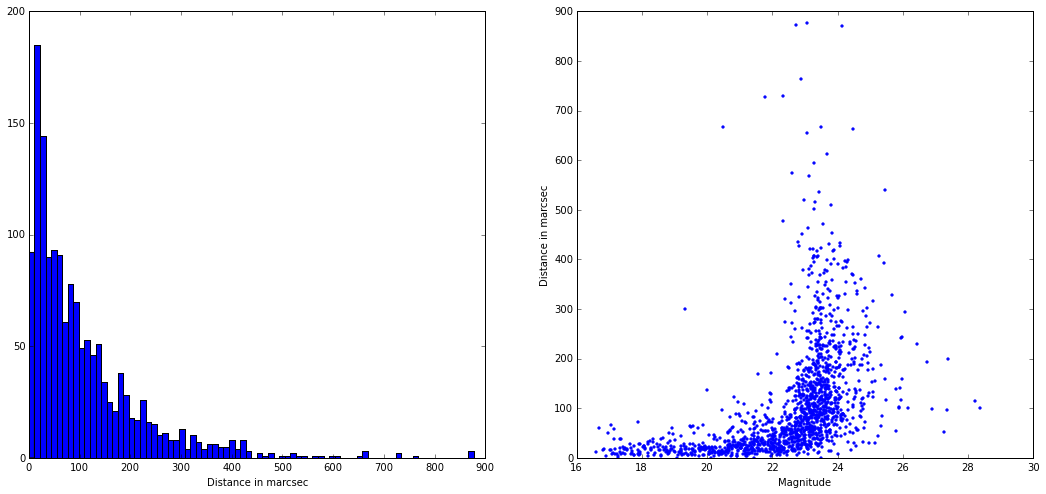

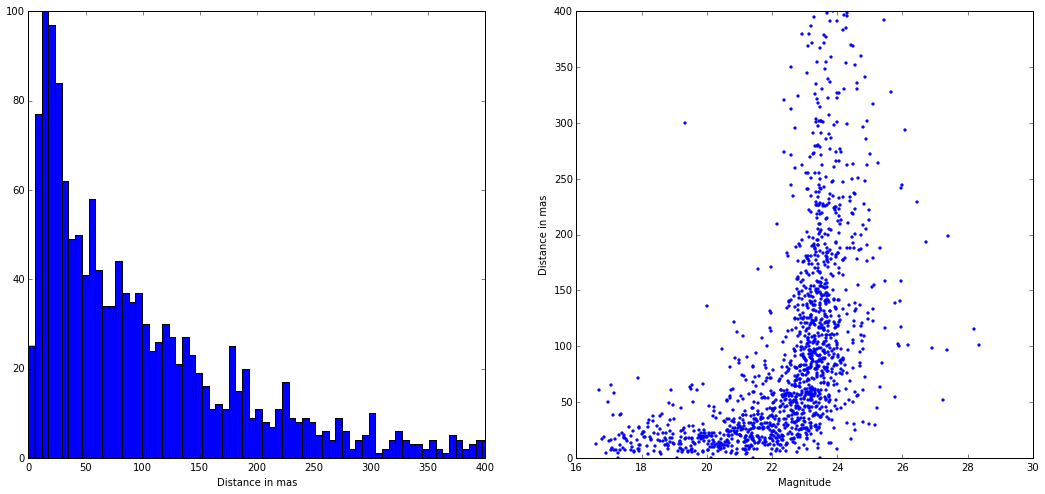

Median value of the astrometric scatter : 74.1488080167 mas


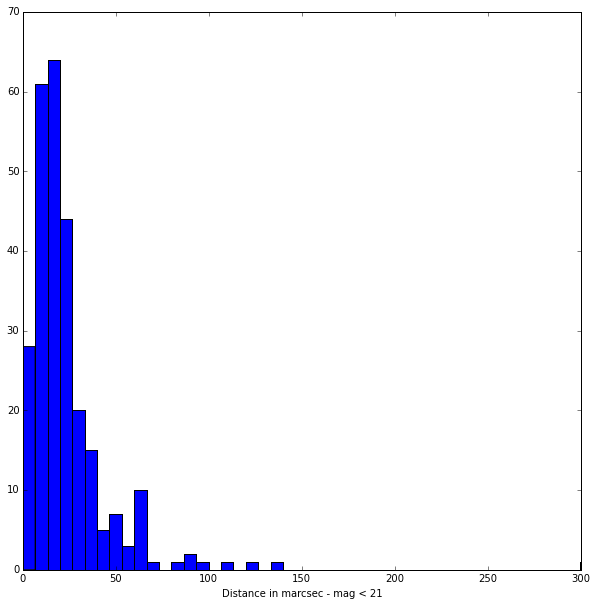

Astrometric scatter (median) - mag < 21 : 18.1835748286 mas


In [45]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,
                                                 8))
ax0.hist(oldDist, bins=80)
ax1.scatter(mag, oldDist, s=5, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, oldDist, s=5, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(oldDist), "mas"

idxs = np.where(np.asarray(mag) < 21)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=100)
ax0.set_xlabel("Distance in marcsec - mag < 21")
ax0.set_xlim([0,300])
plt.show()

print "Astrometric scatter (median) - mag < 21 :", np.median(np.asarray(oldDist)[idxs]), "mas"

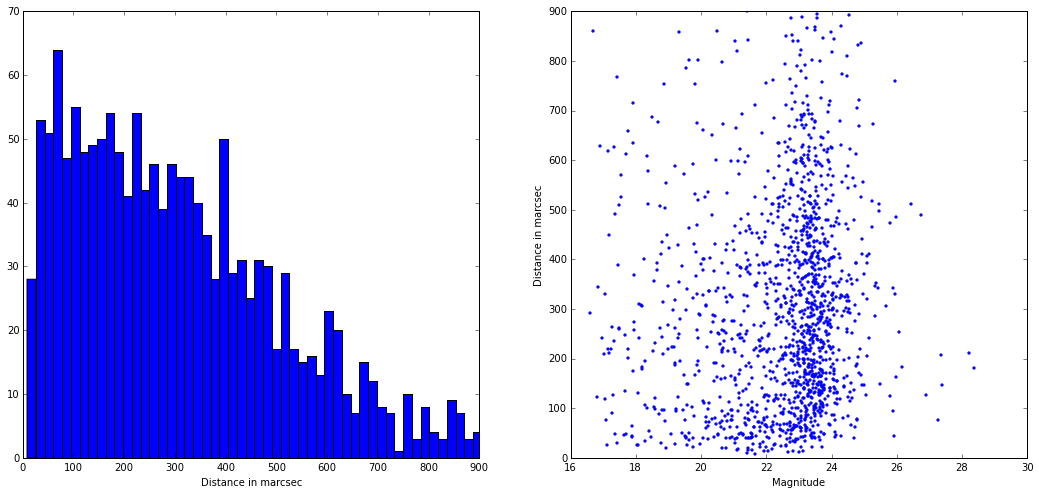

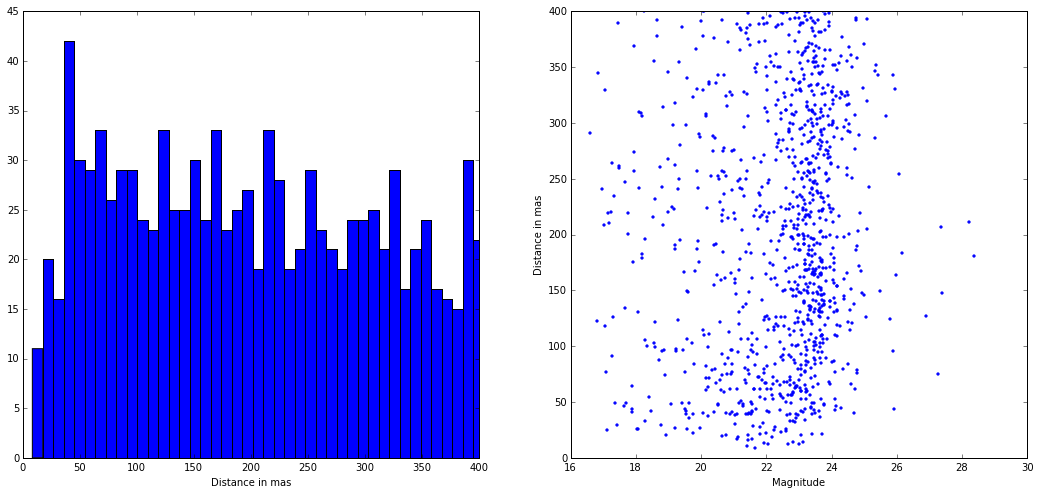

Median value of the astrometric scatter : 271.766108393 mas


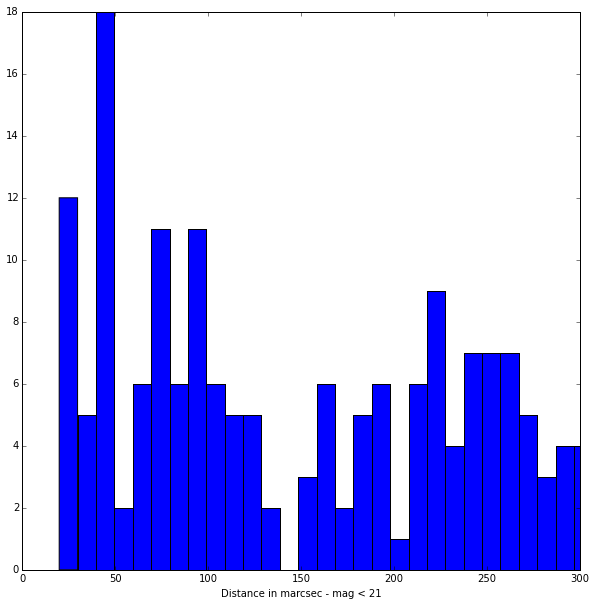

Astrometric scatter (median) - mag < 21 : 240.995256697 mas


In [46]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,
                                                 8))
ax0.hist(newDist, bins=80)
ax1.scatter(mag, newDist, s=5, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=5, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(newDist), "mas"

idxs = np.where(np.asarray(mag) < 21)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs], bins=100)
ax0.set_xlabel("Distance in marcsec - mag < 21")
ax0.set_xlim([0,300])
plt.show()

print "Astrometric scatter (median) - mag < 21 :", np.median(np.asarray(newDist)[idxs]), "mas"

In [56]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

dataid = {'visit':849375, 'filter':'r', 'ccd':12}
dataid2 = {'visit':849375, 'filter':'r', 'ccd':12, 'tract':1 }
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output/coadd_r_dir")

exp = butler.get('calexp', dataid2, immediate=True)
wcsCont = butler.get('wcs', dataid2, immediate=True)
newWcs = afwImage.TanWcs.cast(wcsCont.getWcs())
src = butler.get('src', dataid, immediate=True)

md = butler.get("calexp_md",dataid, immediate=True)
oldWcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))

oldCoord = src[10].get("coord")
print oldCoord.getRa(), oldCoord.getDec()
oldRa = src[10].getRa()
oldDec = src[10].getDec()
print "old Coord", oldCoord

pixels = oldWcs.skyToPixel(oldCoord)
cc = oldWcs.pixelToSky(pixels).toIcrs()
print "Coord with reverse transformation - old WCS", cc
print "pixels with old wcs", pixels
newCoord = newWcs.pixelToSky(pixels).toIcrs()
newPixels = newWcs.skyToPixel(newCoord)
print "pixels with new wcs", newPixels
print newCoord
print

point = afwGeom.Point2D(100., 200.)
newCoord = newWcs.pixelToSky(point)
pointCheck = newWcs.skyToPixel(newCoord)

print "Verif new wcs - Point", point, "should be equal to ", pointCheck

point = afwGeom.Point2D(100., 200.)
oldCoord = oldWcs.pixelToSky(point)
pointCheck = oldWcs.skyToPixel(oldCoord)

print "Verif old wcs - Point", point, "should be equal to ", pointCheck

3.75412 rad 0.923156 rad
old Coord IcrsCoord(215.0951568, 52.8929661)
Coord with reverse transformation - old WCS IcrsCoord(215.0951568, 52.8929661)
pixels with old wcs (1566.5, 49.255)
pixels with new wcs (1562.1, 54.039)
IcrsCoord(215.0947958, 52.8927218)

Verif new wcs - Point (100, 200) should be equal to  (98.142, 203.68)
Verif old wcs - Point (100, 200) should be equal to  (100, 200)
